In [1]:
# taken from https://github.com/nilsec/micron/blob/0f0807d1f45e398ea04e04e7f7cdeafd1a0dab8d/micron/post/analyse_graph.py#L288-L326
import operator


def interpolate_on_grid(z0, y0, x0, z1, y1, x1, voxel_size):
    """
    Interpolate a line on a 3D voxel grid.
    x0, y0, ... (int, physical space e.g. nm):
    returns: list of voxels forming a line from p0 to p1
    """

    def dda_round(x):
        return (x + 0.5).astype(int)

    start = np.array([z0, y0, x0], dtype=float)
    end = np.array([z1, y1, x1], dtype=float)

    voxel_size = np.array(voxel_size)
    if np.any(start % voxel_size) or np.any(end % voxel_size):
        print(start % voxel_size, end % voxel_size)
        raise ValueError("Start end end position must be multiples of voxel size")

    line = [dda_round(start / voxel_size)]

    if not np.any(start - end):
        return line

    max_direction, max_length = max(
        enumerate(abs(end - start)), key=operator.itemgetter(1)
    )

    dv = (end - start) / max_length

    # We interpolate in physical space to find the shortest distance
    # linear interpolation but the path is represented in voxels
    for step in range(int(max_length)):
        step_point_rescaled = np.array(
            dda_round(dda_round((step + 1) * dv + start) / voxel_size)
        )
        if not np.all(step_point_rescaled == line[-1]):
            line.append(step_point_rescaled)

    assert np.all(line[-1] == dda_round(end / voxel_size))
    return line


# from /nrs/funke/ecksteinn/nils_data/cosem_data/cosem_runs/full_cell/cosem_hela_2_full/00_data/exports/read_nml.py
from xml.dom import minidom
import numpy as np


def parse_nml(filename, edge_attribute=None):
    doc = minidom.parse(filename)
    annotations = doc.getElementsByTagName("thing")

    annotation_edge_dict = {}
    node_dic = {}
    edge_list = []
    for annotation in annotations:
        current_edge_list = []
        nodes = annotation.getElementsByTagName("node")
        for node in nodes:
            node_position, node_id = parse_node(node)
            node_dic[node_id] = node_position

        edges = annotation.getElementsByTagName("edge")

        for edge in edges:
            (source_id, target_id) = parse_attributes(
                edge, [["source", int], ["target", int]]
            )
            edge_list.append((source_id, target_id))
            current_edge_list.append((source_id, target_id))

        annotation_id = parse_attributes(annotation, [["id", int]])[0]
        annotation_edge_dict[annotation_id] = current_edge_list

    return node_dic, edge_list, annotation_edge_dict


def parse_node(node):
    [x, y, z, id_] = parse_attributes(
        node,
        [
            ["x", float],
            ["y", float],
            ["z", float],
            ["id", int],
        ],
    )

    point = np.array([z, y, x])

    return point, id_


def parse_edge(edge):
    [source, target] = parse_attributes(edge, [["source", int], ["target", int]])

    return source, target


def parse_attributes(xml_elem, parse_input):
    parse_output = []
    attributes = xml_elem.attributes
    for x in parse_input:
        try:
            parse_output.append(x[1](attributes[x[0]].value))
        except KeyError:
            parse_output.append(None)
    return parse_output

In [2]:
node_dic, edge_list, annotation_edge_dict = parse_nml(
    "/groups/cellmap/cellmap/jonesa/trackmate/fordavid/mt_updated.nml",
    edge_attribute=None,
)
s = (1850, 1500, 2500)
print(max(annotation_edge_dict.keys()))
output = np.zeros(s, dtype=np.uint8)
max_x, max_y, max_z = 0, 0, 0
for id, edge_list in annotation_edge_dict.items():
    for edge in edge_list:
        coords = interpolate_on_grid(*node_dic[edge[0]], *node_dic[edge[1]], 1)
        for coord in coords:
            output[coord[0]][coord[1]][coord[2]] = id

39


In [5]:
import zarr
from numcodecs.gzip import GZip

store = zarr.N5Store("/nrs/cellmap/ackermand/vimentin/convert-knossos-skeletons.n5")
zarr_root = zarr.group(store=store)
ds = zarr_root.create_dataset(
    name="mt_centerAxis",
    data=output,
    shape=output.shape,
    chunks=128,
    write_empty_chunks=True,
    compressor=GZip(level=6),
)
attributes = ds.attrs
attributes["pixelResolution"] = {
    "dimensions": 3 * [2],
    "unit": "nm",
}
attributes["offsets"] = [8600, 4400, 0]  # nm

In [82]:
np.amax(output)

255

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
84
100
101
102
103
104
105
106
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
134
135
136
137
138
139
140
141
142
143
144
145
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
208
210
211
212
213
214
215
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285


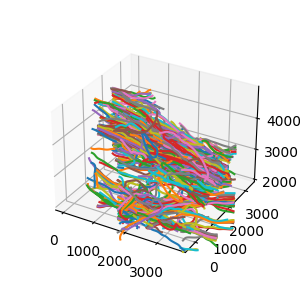

In [1]:
%matplotlib ipympl

from scipy.interpolate import splprep,splev
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.optimize import fmin
from tqdm.notebook import tqdm as log_progress
from interpolation import *
from filaments import *

node_dic, edge_list, annotation_edge_dict = parse_nml("/groups/cellmap/cellmap/jonesa/trackmate/fordavid/vimentin_updated.nml", edge_attribute=None)
s = (1850,1500,2500)

output = np.zeros(s,dtype=np.uint8)
max_x,max_y,max_z = 0,0,0
num_edges = []

count=0
all_bin_to_cos_theta_dict = []
bin_to_cos_theta_dict = {}
bin_to_R_squared_dict = {}
bin_to_delta_squared_dict = {}

all_coords = []

filaments = Filaments(bin_size = 50)
for id,edge_list in annotation_edge_dict.items():
    print(id)
    #if count==587:
    if len(edge_list)>0:
        filaments.add_filament(id, node_dic, edge_list)
        coords = filaments.filament_list[-1].coords
        all_coords.append(coords) 
        #all_bin_to_cos_theta_dict.append(current_bin_to_cos_theta_dict)

        if count==0:
            fig = plt.figure(figsize=(3,3))
            ax = fig.add_subplot(111,projection='3d')
        #ax.scatter3D(x,y,z, c='r')
        #ax.plot3D(x,y,z, '-', c='r')
        ax.plot3D(coords[:,0],coords[:,1],coords[:,2], '-')
        if count==0:
            ax.set_aspect('equal')
    count+=1

filaments.combine_filaments_info()

In [22]:
import pandas as pd

dfs = []
for current_filament in filaments.filament_list:
    df = pd.DataFrame()
    labels = [
        f"Filament {current_filament.id} Point {i}"
        for i in range(len(current_filament.coords))
    ]
    x = current_filament.coords[:, 0]
    y = current_filament.coords[:, 1]
    z = current_filament.coords[:, 2]

    df[f"Filament {current_filament.id} labels"] = labels
    df[f"Filament {current_filament.id} x"] = x
    df[f"Filament {current_filament.id} y"] = y
    df[f"Filament {current_filament.id} z"] = z
    dfs.append(df)
combined_df = pd.concat(dfs, ignore_index=True, axis=1)
combined_df = combined_df.replace(np.nan, "", regex=True)
combined_df.to_csv(
    "/nrs/cellmap/ackermand/vimentin/forAndy/vimentin_annotations_spline.csv",
    index=False,
    header=False,
)

In [19]:
filaments.filament_list[500].original_coords

array([[2.000e+00, 2.360e+03, 1.870e+03],
       [1.420e+02, 2.400e+03, 1.874e+03]])

## New one from Alyson for Andy on 2/26/24

491
490
489
488
487
486
485
484
483
482
481
480
479
478
477
476
475
474
473
472
471
470
469
468
467
466
465
464
463
462
461
460
459
458
457
456
455
454
453
452
451
450
449
448
447
446
445
444
443
442
441
440
439
438
437
436
435
434
433
432
431
430
429
428
427
426
425
424
423
422
421
420
419
418
417
416
415
414
413
412
411
410
409
408
407
405
404
403
402
401
400
399
398
397
396
394
393
392
391
390
389
388
387
386
385
384
383
382
381
380
379
378
377
376
375
374
373
372
371
370
369
368
367
366
364
363
362
361
360
359
358
357
356
355
354
353
352
351
350
349
348
347
346
345
344
343
342
341
340
339
338
337
336
334
333
332
331
330
329
328
327
326
325
324
322
321
320
319
318
317
316
314
313
312
311
310
309
308
307
306
305
304
303
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
265
264
263
262
261
260
259
258
257
256
255
254
253
252
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233


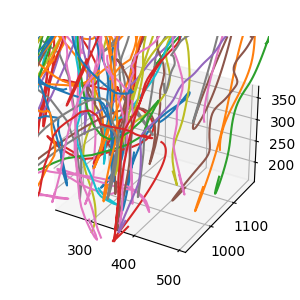

In [4]:
%matplotlib ipympl

from scipy.interpolate import splprep,splev
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.optimize import fmin
from tqdm.notebook import tqdm as log_progress
from interpolation import *
from filaments import *

node_dic, edge_list, annotation_edge_dict = parse_nml("/nrs/cellmap/jonesa/forandy/vimentin_crop4.nml", edge_attribute=None)
s = (1850,1500,2500)

output = np.zeros(s,dtype=np.uint8)
max_x,max_y,max_z = 0,0,0
num_edges = []

count=0
all_bin_to_cos_theta_dict = []
bin_to_cos_theta_dict = {}
bin_to_R_squared_dict = {}
bin_to_delta_squared_dict = {}

all_coords = []

filaments = Filaments(bin_size = 50)
for id,edge_list in annotation_edge_dict.items():
    print(id)
    #if count==587:
    if len(edge_list)>0:
        filaments.add_filament(id, [node_dic, edge_list])
        coords = filaments.filament_list[-1].coords
        all_coords.append(coords) 
        #all_bin_to_cos_theta_dict.append(current_bin_to_cos_theta_dict)

        if count==0:
            fig = plt.figure(figsize=(3,3))
            ax = fig.add_subplot(111,projection='3d')
        #ax.scatter3D(x,y,z, c='r')
        #ax.plot3D(x,y,z, '-', c='r')
        ax.plot3D(coords[:,0],coords[:,1],coords[:,2], '-')
        if count==0:
            ax.set_aspect('equal')
    count+=1

filaments.combine_filaments_info()

In [17]:
ax.set_xlim([0, 400])
ax.set_ylim([0, 2000])
ax.set_zlim([0, 2000])

(0.0, 2000.0)

In [6]:
import pandas as pd

dfs = []
for current_filament in filaments.filament_list:
    df = pd.DataFrame()
    labels = [
        f"Filament {current_filament.id} Point {i}"
        for i in range(len(current_filament.coords))
    ]
    x = current_filament.coords[:, 0]
    y = current_filament.coords[:, 1]
    z = current_filament.coords[:, 2]

    df[f"Filament {current_filament.id} labels"] = labels
    df[f"Filament {current_filament.id} x"] = x
    df[f"Filament {current_filament.id} y"] = y
    df[f"Filament {current_filament.id} z"] = z
    dfs.append(df)
combined_df = pd.concat(dfs, ignore_index=True, axis=1)
combined_df = combined_df.replace(np.nan, "", regex=True)
combined_df.to_csv(
    "/nrs/cellmap/ackermand/vimentin/forAndy/20240226/vimentin_annotations_spline.csv",
    index=False,
    header=False,
)

In [21]:
current_filament.original_coords

array([[ 242.,  780.,  816.],
       [ 228.,  758.,  804.],
       [ 254.,  804.,  816.],
       [ 268.,  832.,  822.],
       [ 286.,  866.,  822.],
       [ 296.,  910.,  822.],
       [ 294.,  942.,  822.],
       [ 288.,  972.,  824.],
       [ 284.,  990.,  824.],
       [ 274., 1022.,  824.],
       [ 258., 1056.,  840.],
       [ 250., 1076.,  860.],
       [ 244., 1090.,  882.],
       [ 232., 1116.,  926.],
       [ 222., 1128.,  958.],
       [ 218., 1144.,  996.],
       [ 212., 1172., 1028.],
       [ 208., 1186., 1044.],
       [ 208., 1204., 1056.],
       [ 206., 1224., 1070.],
       [ 200., 1246., 1088.],
       [ 198., 1266., 1100.],
       [ 196., 1288., 1112.],
       [ 192., 1318., 1126.],
       [ 190., 1350., 1144.],
       [ 190., 1384., 1160.],
       [ 192., 1418., 1178.],
       [ 190., 1448., 1196.],
       [ 184., 1468., 1208.],
       [ 184., 1498., 1224.],
       [ 190., 1560., 1246.],
       [ 200., 1596., 1266.],
       [ 204., 1632., 1284.],
       [ 2

164 4.035515830902344


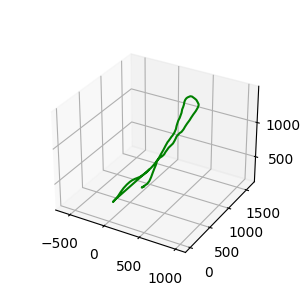

In [35]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection="3d")
for current_filament in filaments.filament_list:
    coords = current_filament.coords
    original_coords = current_filament.original_coords
    #if np.amin(current_filament.coords) < -40:
    if current_filament.id == 164:
        #ax.plot3D(coords[:, 0], coords[:, 1], coords[:, 2], "r-")
        ax.plot3D(original_coords[:, 0], original_coords[:, 1], original_coords[:, 2], "g-")
        print(current_filament.id, np.amin(current_filament.coords))
        break
ax.set_aspect('equal')
